In [1]:
# !pip install pycaret
# !pip install catboost

In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
# from pycaret import *
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from pycaret.classification import *
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, confusion_matrix

In [3]:
train=pd.read_csv('train.csv')
submission = pd.read_csv('label.csv')

In [4]:
train.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50


In [5]:
train['datetime'] = pd.to_datetime(train['order_date'])
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month

In [6]:
def year_month(x):
    return x[:7]

In [7]:
train['year_month'] = train['order_date'].apply(year_month)

In [8]:
train_predict = train[train['year_month'] != '2011-11']

## year_month별 total

In [9]:
train_predict.year_month.value_counts()

2010-11    60081
2011-10    49928
2010-10    49719
2011-09    40459
2010-09    34911
2010-03    32592
2010-06    31447
2009-12    31276
2010-05    29191
2011-05    28661
2011-06    27576
2011-03    27516
2011-08    27444
2010-04    27429
2010-07    27357
2011-07    27256
2010-08    26577
2010-12    26354
2010-02    23578
2011-04    22988
2010-01    22122
2011-01    21670
2011-02    20138
Name: year_month, dtype: int64

<AxesSubplot:xlabel='total', ylabel='year_month'>

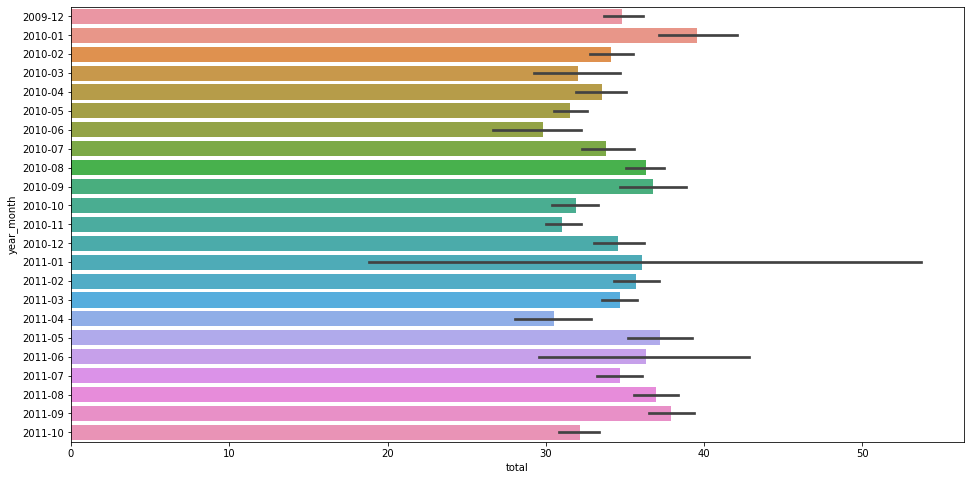

In [10]:
plt.figure(figsize = (16,8))
sns.barplot(data = train_predict, y = 'year_month', x = 'total')

- year_month별로 각 달의 특성이 있다고 판단을 했고 더미화를 해주고 그 year_month에 300이상이면 1 아니면 0으로 넣었습니다.

In [11]:
train_cust=pd.pivot_table(train, index = 'customer_id', columns = 'year_month', values = 'total', aggfunc = 'sum')

In [12]:
train_cust

year_month,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11
customer_id,,,,,,,,,,,,,,,,,,,,,,,,
12346,187.2750,-22.275,NaN,44.6325,NaN,NaN,-285.9285,NaN,NaN,NaN,-9.0750,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1009.0245,NaN,1174.4535,784.3935,NaN,NaN,1049.8125,NaN,631.158,NaN,965.1015,NaN,2135.6280,NaN
12348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,366.564,NaN,NaN,1473.1200,375.2760,NaN,NaN,605.5500,NaN,NaN,NaN,NaN,511.500,NaN,NaN
12349,-39.8475,NaN,NaN,NaN,1763.058,330.0000,NaN,NaN,NaN,NaN,2314.3230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2899.9575
12350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,551.7600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18283,NaN,NaN,159.885,387.9480,NaN,NaN,NaN,NaN,151.800,NaN,NaN,322.3275,NaN,352.6875,166.5675,NaN,190.7400,140.613,489.258,230.8185,NaN,222.585,186.4335,1052.2215
18284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,720.5220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18285,NaN,NaN,704.550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# target 변수와 동일한 방식대로 300 이상은 1 300이하는 0으로 변경했습니다.
def solution(x):
    if x > 300:
        return 1
    else:
        return 0

In [14]:
train_cust=train_cust.fillna(0)
for i in train_cust.columns:
    train_cust[i] = train_cust[i].apply(solution)

In [15]:
train_cust

year_month,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11
customer_id,,,,,,,,,,,,,,,,,,,,,,,,
12346,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12347,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0
12348,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0
12349,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
12350,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18283,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1
18284,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
18285,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# 산사람과 환불한사람

In [16]:
# C가 없는 index C가 있는 index를 구분하였습니다.
a = []
not_in_c = []
for i in train_predict.index:
    if train_predict.loc[i,'order_id'][0] == 'C':
        a.append(i)
    else:
        not_in_c.append(i)

In [17]:
# 환불한 사람은 train_predict_refund에 구매한 사람은 train_predict_not_refund에 테이블을 생성해 주었습니다.
train_predict_refund=train_predict.loc[a,:]
train_predict_not_refund = train_predict.loc[not_in_c,:]

In [18]:
train_predict_refund.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,datetime,year,month,year_month
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,4.8675,16321,Australia,-58.410,2009-12-01 10:33:00,2009,12,2009-12
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,2.7225,16321,Australia,-16.335,2009-12-01 10:33:00,2009,12,2009-12
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,7.0125,16321,Australia,-28.050,2009-12-01 10:33:00,2009,12,2009-12
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,3.4650,16321,Australia,-20.790,2009-12-01 10:33:00,2009,12,2009-12
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,4.8675,16321,Australia,-58.410,2009-12-01 10:33:00,2009,12,2009-12


In [19]:
train_predict_not_refund.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,datetime,year,month,year_month
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61,2009-12-01 07:45:00,2009,12,2009-12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,2009-12-01 07:45:00,2009,12,2009-12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,2009-12-01 07:45:00,2009,12,2009-12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32,2009-12-01 07:45:00,2009,12,2009-12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50,2009-12-01 07:45:00,2009,12,2009-12


Text(0.5, 1.0, '달마다 구매한 total')

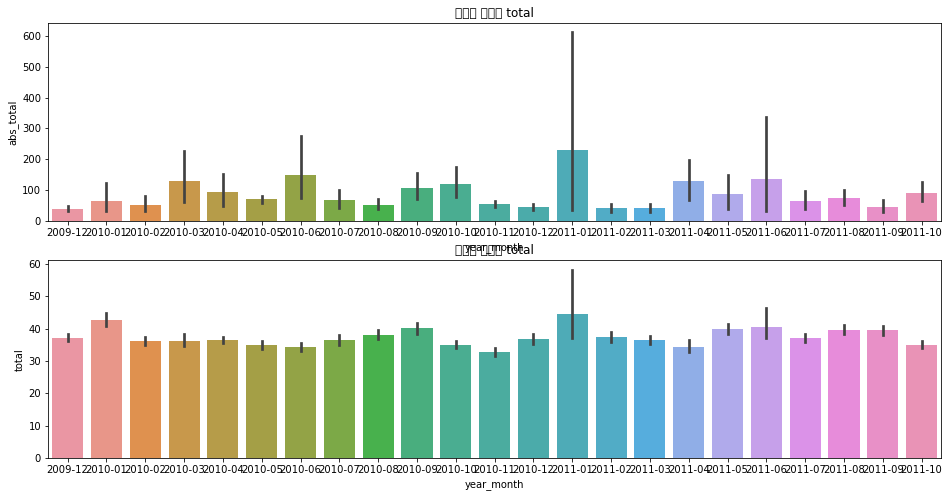

In [20]:
# train_predict_refund에는 절댓값을 씌워줘서 비교하기 편하게 만들었다.
train_predict_refund['abs_total'] = train_predict_refund['total'].apply(lambda x:abs(x))

fig, ax = plt.subplots(nrows = 2, figsize = (16,8))
sns.barplot(data = train_predict_refund, x = 'year_month', y = 'abs_total', ax = ax[0])
ax[0].set_title('달마다 환불한 total')

sns.barplot(data = train_predict_not_refund, x = 'year_month', y = 'total', ax = ax[1])
ax[1].set_title('달마다 구매한 total')

- 환불한 그래프와 구매한 그래프의 모양이 다르기 때문에 구매한 횟수와 환불한 횟수를 변수로 넣어줘야겠다 생각했습니다.

## 월 별 환불과 월 별 구매수

In [21]:
train_predict_refund=pd.pivot_table(train_predict_refund, index = 'customer_id', columns = 'year_month', values = 'price', aggfunc = 'count')
train_predict_purchase = pd.pivot_table(train_predict_not_refund, index = 'customer_id', columns = 'year_month', values = 'price',aggfunc = 'count')

In [22]:
train_predict_refund.head()

year_month,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10
customer_id,,,,,,,,,,,,,,,,,,,,,,,
12346,NaN,1.0,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12349,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12359,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
12360,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
train_predict_purchase.head()

year_month,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10
customer_id,,,,,,,,,,,,,,,,,,,,,,,
12346,5.0,4.0,NaN,5.0,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,NaN,31.0,29.0,NaN,NaN,24.0,NaN,18.0,NaN,22.0,NaN,47.0
12348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,NaN,NaN,17.0,6.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,3.0,NaN
12349,NaN,NaN,NaN,NaN,46.0,1.0,NaN,NaN,NaN,NaN,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
train_cust = train_cust.join(train_predict_purchase, how = 'left',on = 'customer_id',rsuffix= '구매한 횟수')
train_cust = train_cust.join(train_predict_refund, how = 'left', on = 'customer_id',lsuffix = '환불한 횟수')

In [26]:
train_cust

year_month,2009-12환불한 횟수,2010-01환불한 횟수,2010-02환불한 횟수,2010-03환불한 횟수,2010-04환불한 횟수,2010-05환불한 횟수,2010-06환불한 횟수,2010-07환불한 횟수,2010-08환불한 횟수,2010-09환불한 횟수,2010-10환불한 횟수,2010-11환불한 횟수,2010-12환불한 횟수,2011-01환불한 횟수,2011-02환불한 횟수,2011-03환불한 횟수,2011-04환불한 횟수,2011-05환불한 횟수,2011-06환불한 횟수,2011-07환불한 횟수,2011-08환불한 횟수,2011-09환불한 횟수,2011-10환불한 횟수,2011-11,2009-12구매한 횟수,2010-01구매한 횟수,2010-02구매한 횟수,2010-03구매한 횟수,2010-04구매한 횟수,2010-05구매한 횟수,2010-06구매한 횟수,2010-07구매한 횟수,2010-08구매한 횟수,2010-09구매한 횟수,2010-10구매한 횟수,2010-11구매한 횟수,2010-12구매한 횟수,2011-01구매한 횟수,2011-02구매한 횟수,2011-03구매한 횟수,2011-04구매한 횟수,2011-05구매한 횟수,2011-06구매한 횟수,2011-07구매한 횟수,2011-08구매한 횟수,2011-09구매한 횟수,2011-10구매한 횟수,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12346,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,4.0,NaN,5.0,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12347,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,NaN,31.0,29.0,NaN,NaN,24.0,NaN,18.0,NaN,22.0,NaN,47.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12348,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,NaN,NaN,17.0,6.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12349,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,46.0,1.0,NaN,NaN,NaN,NaN,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12350,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18283,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,NaN,NaN,40.0,79.0,NaN,NaN,NaN,NaN,39.0,NaN,NaN,59.0,NaN,101.0,29.0,NaN,55.0,37.0,100.0,55.0,NaN,47.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18284,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18285,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## product_id

In [27]:
train_predict['product_id'].value_counts()

85123A    4856
22423     3442
85099B    3120
20725     2521
84879     2465
          ... 
20891        1
21346        1
37484        1
79303A       1
21254        1
Name: product_id, Length: 4620, dtype: int64

In [28]:
def solution(x):
    return x[:5]

In [29]:
train_predict['product_id'] = train_predict['product_id'].apply(solution)

In [30]:
train_prod_unique=train_predict['product_id'].unique()
a = []
for i in train_prod_unique:
    try:
        i=int(i)
    except:
        a.append(i)
print(a)

['POST', 'D', 'M', 'C2', 'BANK ', 'TEST0', 'PADS', 'ADJUS', 'SP100', 'DOT', 'CRUK']


In [31]:
b = []
for i in train.index:
    if train.loc[i,'product_id'] in a:
        b.append(i)

Text(0.5, 1.0, 'barplot')

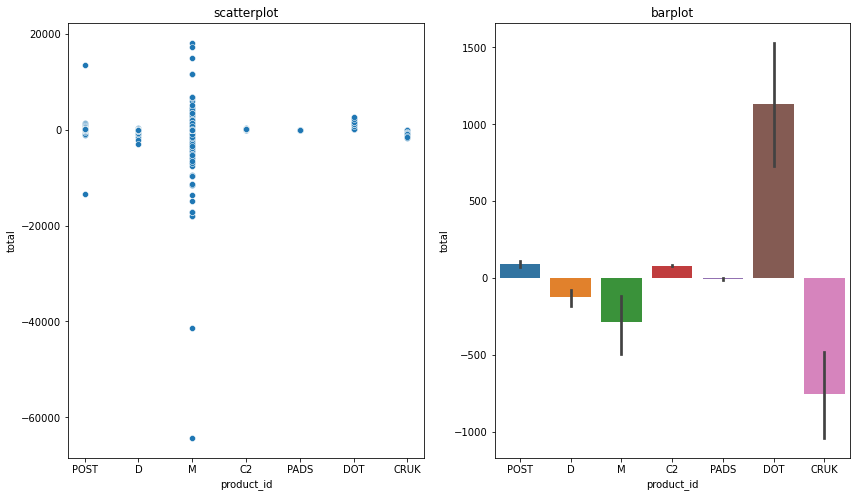

In [32]:
fig, ax = plt.subplots(ncols = 2, figsize = (14,8))
sns.scatterplot(data = train.loc[b,:], x = 'product_id', y = 'total', ax = ax[0])
ax[0].set_title('scatterplot')

sns.barplot(data = train.loc[b,:], x = 'product_id', y = 'total', ax = ax[1])
ax[1].set_title('barplot')

- 각 변수들마다 뚜렷한 차이가 있지만 뚜렷하게 해줄 방법이 생각나질 않기 때문에 하나의 값에 몰아서 넣어주자.

In [33]:
for i in a:
    train_predict.loc[train_predict['product_id'] == i,'product_id'] = '99999'

In [34]:
# 글자의 갯수를 3개로 제한해서 데이터를 줄어준다.
train_predict['product_id'] = train_predict['product_id'].apply(lambda x: x[:3])
train_predict['product_id'] = train_predict['product_id'].astype('int')

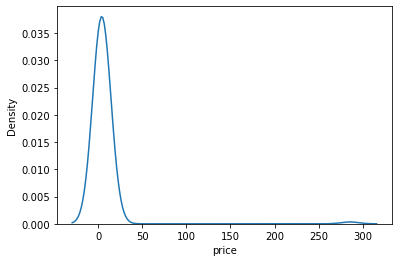

count    118.000000
mean       6.576246
std       26.044816
min        0.598714
25%        2.046932
50%        3.601735
75%        5.685980
max      285.520341
Name: price, dtype: float64

In [35]:
# product_id별 price의 평균의 4분위수로 나눠주자.
train_product_id=train_predict.groupby('product_id')['price'].mean()

sns.kdeplot(data = train_product_id)
plt.show()

train_product_id.describe()

In [36]:
product_id=pd.DataFrame(train_product_id)
product_id.loc[product_id['price'] <= 2.046932, 'price'] = 0
product_id.loc[(product_id['price'] > 2.046932) & (product_id['price'] <= 3.601735), 'price'] = 1
product_id.loc[(product_id['price'] >3.601735) & (product_id['price'] <= 5.685980), 'price'] = 2
product_id.loc[product_id['price'] >5.685980, 'price'] = 3

In [37]:
product_id

,price
product_id,
100,0.0
101,0.0
110,1.0
150,3.0
160,0.0
161,0.0
162,0.0
170,0.0
171,0.0


In [38]:
# 우리는 product_id별 범주화를 train에 적용시켜 주었습니다.
mapping = {}
for i,j in zip(product_id.index,product_id.price):
    mapping[i] = j

In [39]:
train_predict['product_id'] = train_predict['product_id'].map(mapping)

In [40]:
product_id=pd.pivot_table(train_predict, index = 'customer_id', columns = 'product_id', values = 'price', aggfunc = 'count')
product_id.fillna(0)
train_cust = train_cust.join(product_id, how = 'left', on = 'customer_id')

## price

<AxesSubplot:xlabel='price', ylabel='Density'>

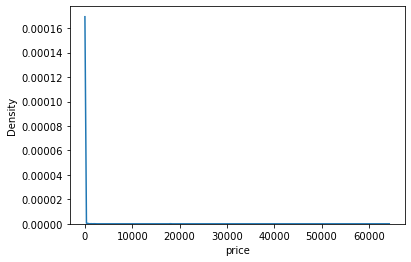

In [41]:
sns.kdeplot(data = train_predict, x = 'price')

In [42]:
# 너무 치우쳐져 있기 때문에 로그를 씌워주자.
train_predict['price'] = train_predict['price'].apply(lambda x: np.log1p(x))

<AxesSubplot:xlabel='price', ylabel='Density'>

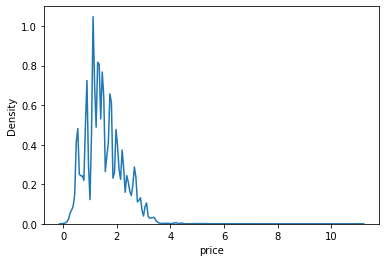

In [43]:
sns.kdeplot(train_predict['price'])

- 대부분의 데이터가 0~3 사이에 있다.
- 0. price <= 1 
- 1. 1 < price <= 2 
- 2. 2 < price <= 3 
- 3. 3 < price
- 0,1,2,3으로 범주화를 시켜주고 그래프를 그려서 데이터와 total을 찍어본다.

In [44]:
train_predict.loc[train_predict['price'] <= 1,'price'] = 0
train_predict.loc[(train_predict['price'] > 1) & (train_predict['price'] <= 2),'price'] = 1
train_predict.loc[(train_predict['price'] > 2) & (train_predict['price'] <= 3),'price'] = 2
train_predict.loc[(train_predict['price'] > 3) ,'price'] = 3

In [45]:
train_predict['price'].value_counts()

1.0    399782
0.0    155508
2.0    142141
3.0     18839
Name: price, dtype: int64

<AxesSubplot:xlabel='price', ylabel='total'>

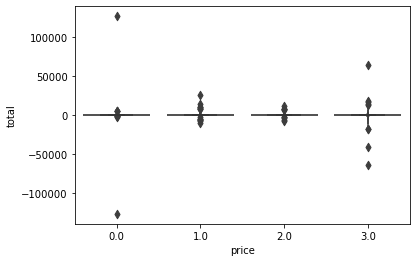

In [46]:
sns.boxenplot(data = train_predict, x = 'price', y = 'total')

<AxesSubplot:xlabel='price', ylabel='total'>

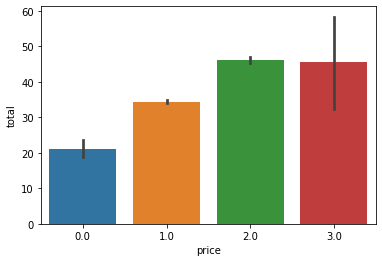

In [47]:
sns.barplot(data = train_predict, x = 'price', y = 'total')

In [48]:
price = pd.pivot_table(train_predict, index = 'customer_id', columns = 'price', values = 'total', aggfunc = 'count')

In [49]:
price

price,0.0,1.0,2.0,3.0
customer_id,,,,
12346,4.0,2.0,34.0,7.0
12347,56.0,118.0,32.0,5.0
12348,36.0,11.0,NaN,4.0
12349,15.0,53.0,31.0,8.0
12350,3.0,13.0,NaN,1.0
...,...,...,...,...
18283,173.0,465.0,40.0,1.0
18284,14.0,12.0,1.0,2.0
18285,2.0,4.0,4.0,2.0


In [50]:
train_cust=train_cust.join(price, how = 'left', on = 'customer_id', rsuffix='_price')

## country

<AxesSubplot:xlabel='total', ylabel='country'>

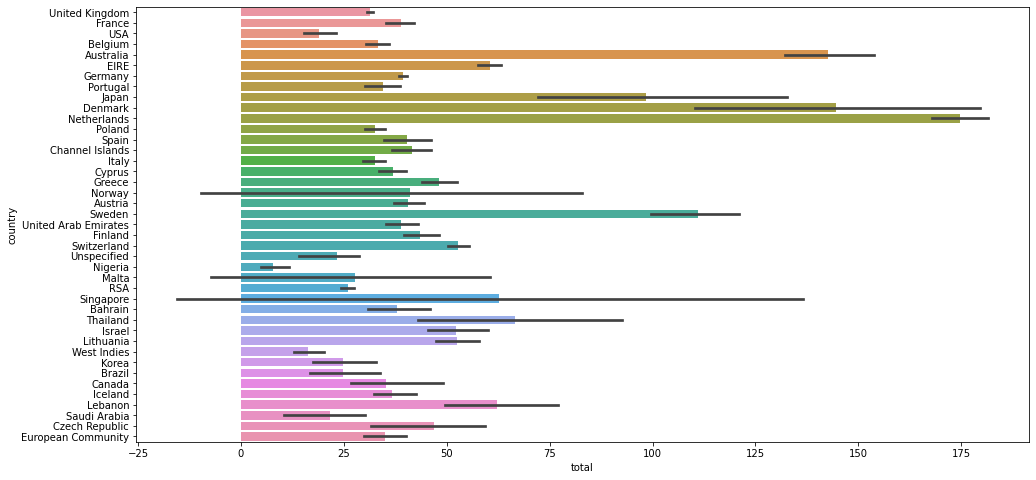

In [51]:
plt.figure(figsize =(16,8))
sns.barplot(data = train_predict, y = 'country', x = 'total')

<AxesSubplot:xlabel='count', ylabel='country'>

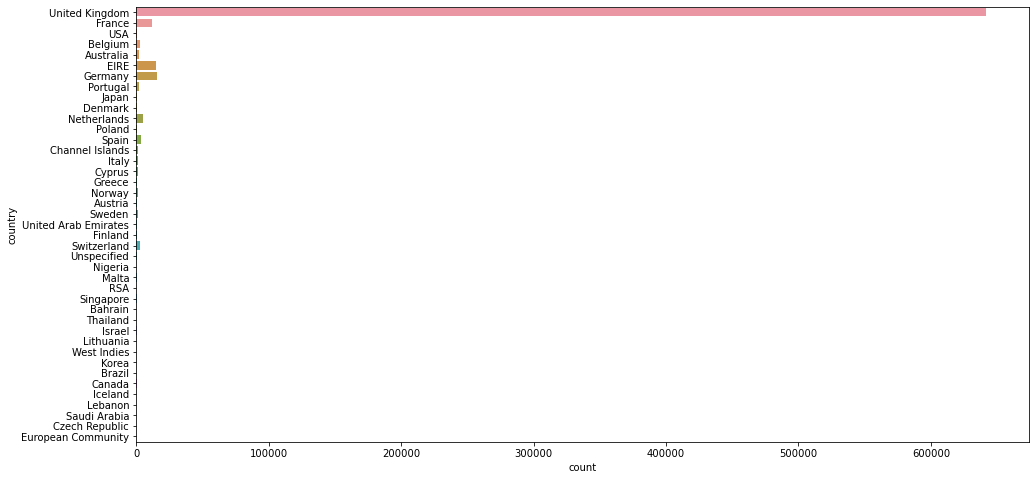

In [52]:
plt.figure(figsize = (16,8))
sns.countplot(data = train_predict, y = 'country')
# United Kingdom이 가장 많이 비율을 차지하고 있고 우리는 United Kingdom은 1 아니면 0으로 데이터를 바꿔주도록 하자.

In [53]:
train_predict.loc[train_predict['country'] != 'United Kingdom', 'country'] = 0
train_predict.loc[train_predict['country'] == 'United Kingdom', 'country'] = 1

In [54]:
train_predict['country'].value_counts()

1    641968
0     74302
Name: country, dtype: int64

<AxesSubplot:xlabel='country', ylabel='total'>

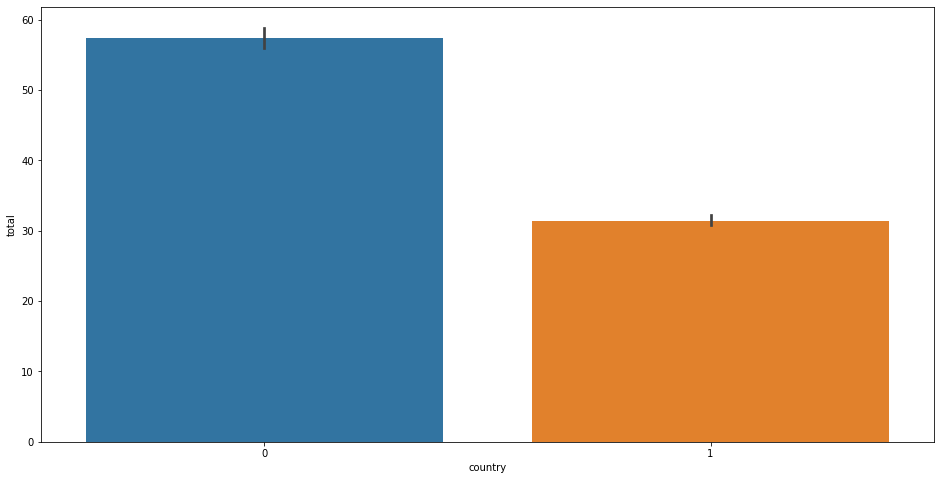

In [55]:
plt.figure(figsize = (16,8))
sns.barplot(data = train_predict, x = 'country', y = 'total')

- total로 비교해봤을 때 좋은 결과가 나올 것 같다.

In [56]:
country=pd.pivot_table(train_predict, index = 'customer_id', columns = 'country', values = 'price', aggfunc = 'count')

In [57]:
country.shape

(5722, 2)

In [58]:
def test1(x):
    if x > 0:
        return 1
    else:
        return 0

In [59]:
country_columns=country.columns
for i in country_columns:
    country[i] = country[i].apply(test1)

In [60]:
train_cust=train_cust.join(country, how = 'left', on = 'customer_id',rsuffix  = 'United Kingdom 여부')

In [61]:
train_cust=train_cust.fillna(0)

## 각 customer_id의 total_sum

In [62]:
total_sum=train.groupby('customer_id')['total'].sum()
train_cust=train_cust.join(total_sum, how = 'left', on = 'customer_id')

- customer_id가 2009-12 월부터 2011- 10월까지 얼마를 썻는지도 변수에 넣어주었다.

In [63]:
train_cust.shape

(5914, 81)

In [64]:
target = train_cust.loc[:,'2011-11']
data = train_cust.drop('2011-11', axis = 1)

In [65]:
data.isnull().sum().sum()

0

In [66]:
X_train, X_test,y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 43)

## xgboost

In [67]:
param_grid = {
    'max_depth': [7,9,11,12,13],
    'scale_pos_weight':[1,2,3,4,5,6]
}

xgb=XGBClassifier(seed = 42)
gridsearch=GridSearchCV(estimator = xgb, param_grid = param_grid, scoring = 'roc_auc', cv = 5)
gridsearch.fit(X_train, y_train)
scores_df = pd.DataFrame(gridsearch.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score']]

model_xgb=gridsearch.best_estimator_
y_pred=model_xgb.predict(X_test)
np.mean(y_pred == y_test)

[15:13:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:13:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:13:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:14:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:14:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:14:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:14:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:14:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:15:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:15:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:15:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:15:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:16:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:16:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:16:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:16:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:16:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:17:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:17:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:17:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:17:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:17:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:17:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:17:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

0.8368554522400676

In [68]:
scores_df[scores_df['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_scale_pos_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,1.582751,0.025954,0.014585,0.000689,9,4,"{'max_depth': 9, 'scale_pos_weight': 4}",0.872019,0.880829,0.871293,0.876634,0.906148,0.881385,0.012851,1


## catboost

In [69]:
param_grid = {'max_depth': [9,10],
    'scale_pos_weight':[1,2]}          
cat = CatBoostClassifier(loss_function='Logloss',
          eval_metric ='AUC',
          verbose= 200,
          early_stopping_rounds = 500,
          random_seed = 42,)
gs1 = GridSearchCV(estimator = cat,param_grid = param_grid)
gs1.fit(X_train, y_train)
scores_df = pd.DataFrame(gs1.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score']]

model_cat=gs1.best_estimator_
y_pred=model_cat.predict(X_test)
np.mean(y_pred == y_test)

Learning rate set to 0.018185
0:	total: 209ms	remaining: 3m 28s
200:	total: 7.41s	remaining: 29.5s
400:	total: 14.7s	remaining: 21.9s
600:	total: 21.8s	remaining: 14.5s
800:	total: 29.1s	remaining: 7.22s
999:	total: 36.3s	remaining: 0us
Learning rate set to 0.018187
0:	total: 46.3ms	remaining: 46.2s
200:	total: 6.92s	remaining: 27.5s
400:	total: 13.9s	remaining: 20.8s
600:	total: 21s	remaining: 13.9s
800:	total: 27.9s	remaining: 6.94s
999:	total: 34.8s	remaining: 0us
Learning rate set to 0.018187
0:	total: 44.5ms	remaining: 44.5s
200:	total: 6.96s	remaining: 27.7s
400:	total: 13.8s	remaining: 20.6s
600:	total: 20.8s	remaining: 13.8s
800:	total: 27.8s	remaining: 6.92s
999:	total: 34.8s	remaining: 0us
Learning rate set to 0.018187
0:	total: 48ms	remaining: 48s
200:	total: 7.17s	remaining: 28.5s
400:	total: 14.4s	remaining: 21.4s
600:	total: 21.6s	remaining: 14.4s
800:	total: 28.7s	remaining: 7.14s
999:	total: 36s	remaining: 0us
Learning rate set to 0.018187
0:	total: 40.4ms	remaining: 40

0.8368554522400676

In [70]:
scores_df[scores_df['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_scale_pos_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,36.283742,0.953457,0.015539,0.000468,9,1,"{'max_depth': 9, 'scale_pos_weight': 1}",0.840549,0.849894,0.839323,0.843552,0.85518,0.8457,0.005988,1


## LGBMClassifier

In [71]:
params_grid = {
    'num_leaves' :[27,29],
    'max_depth' : [10,11],
    'min_data_in_leaf' : [18,19],
}
lgb=LGBMClassifier(boosting = 'gbdt')
gs1=GridSearchCV(estimator = lgb, param_grid=params_grid, cv = 5, scoring = 'roc_auc')
gs1.fit(X_train, y_train)
scores_df = pd.DataFrame(gs1.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score']]

model_lgb=gs1.best_estimator_
y_pred=model_lgb.predict(X_test)
np.mean(y_pred == y_test)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

0.852916314454776

In [72]:
scores_df[scores_df['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_data_in_leaf,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.376409,0.012624,0.019401,0.001616,10,19,27,"{'max_depth': 10, 'min_data_in_leaf': 19, 'num...",0.88303,0.879878,0.879309,0.87511,0.896695,0.882805,0.007389,1


## LogisticRegression

In [73]:
reg = LogisticRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
np.mean(y_pred == y_test)

0.716821639898563

## KNeighborsClassifier

In [74]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred=knn.predict(X_test)
np.mean(y_test == y_pred)

0.8038884192730347

## RandomForest Classifier

In [75]:
from sklearn.ensemble import RandomForestClassifier

param_grid = { 
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
rfg = RandomForestClassifier(random_state = 42)
gs1 = GridSearchCV(estimator= rfg, param_grid = param_grid, scoring = 'roc_auc', cv = 5)
gs1.fit(X_train, y_train)

scores_df = pd.DataFrame(gs1.cv_results_)
scores_df[['params', 'mean_test_score','rank_test_score']]
model_rfg = gs1.best_estimator_
y_pred = model_rfg.predict(X_test)
np.mean(y_test == y_pred)

0.8326289095519864

## 12월 데이터 예측하기

In [76]:
test=submission['label']

## XGBoost

In [77]:
data_pred=model_xgb.predict(data)
np.mean(data_pred == test)

0.8003043625295908

In [78]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate,thresholds = roc_curve(test, data_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

0.7298121034651048


In [79]:
cf=confusion_matrix(data_pred,test)
print(cf)

[[4442  159]
 [1022  291]]


## Catboost

In [80]:
data_pred = model_cat.predict(data)
np.mean(data_pred == test)

0.8243151843084207

In [81]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(test, data_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

0.7326102163657067


In [82]:
cf=confusion_matrix(data_pred,test)
print(cf)

[[4594  169]
 [ 870  281]]


## LightGBM

In [83]:
data_pred=model_lgb.predict(data)
np.mean(data_pred == test)

0.8280351707811971

In [84]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(test, data_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

0.7244273629412722


In [85]:
cf=confusion_matrix(data_pred,test)
print(cf)

[[4626  179]
 [ 838  271]]


## LogisticRegression

In [86]:
data_pred = reg.predict(data)
np.mean(test == data_pred)

0.7451809266148123

In [87]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(test, data_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

0.6887648446396616


In [88]:
cf=confusion_matrix(data_pred,test)
print(cf)

[[4127  170]
 [1337  280]]


## KNeighborsClassifier

In [89]:
data_pred=knn.predict(data)
np.mean(data_pred == test)

0.8214406493067298

In [90]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(test, data_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

0.6974076785423784


In [91]:
cf=confusion_matrix(data_pred,test)
print(cf)

[[4610  202]
 [ 854  248]]


## RandomForestClassifier

In [92]:
data_pred=model_rfg.predict(data)
np.mean(data_pred == test)

0.8823131552248901

In [93]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(test, data_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

0.6895664551813893


In [94]:
cf=confusion_matrix(data_pred,test)
print(cf)

[[5010  242]
 [ 454  208]]
